In [298]:
import pandas as pd
import praw
import re
import nltk


import networkx as nx
import gensim.models


import xgboost as xgb
import numba 
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

import sklearn 
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb

regex = re.compile('[^a-zA-Z ]')

from emoji import emojize, demojize
from urlextract import URLExtract
extractor=URLExtract()

def ReplaceEmojis(text):
    newsentence=""
    for word in demojize(text).split():
        if len(word)>1 and word[0]==":" and word[-1]==":":
            newsentence=newsentence+ "emoji" + word[1:-1] + "emoji "
        else:
            newsentence=newsentence+ word + " "
    return newsentence

def ReplaceURLs(text):
    newsentence=""
    for word in text.split():
        if extractor.has_urls(word):
            newsentence=newsentence+ "URL "
        else:
            newsentence=newsentence+ word + " "
    return newsentence
    

#@numba.jit # unfortunately this doesn't jit easily :(
def tokenize(text):
    # given a body of text, this splits into sentences, then processes each word in the sentence to remove
    # non alphabetical characters... (? bad idea, what about users with numbers in their name)
    # returns it as a list of lists of words, the format desired by gensims word2vec
    
    sentences = []
    if type(text) == str:
        for sentence in nltk.tokenize.sent_tokenize(text):
            #first find and replace URLs in sentence
            #sentence=ReplaceURLs(sentence)
            #then replace the emojis
            #sentence=ReplaceEmojis(sentence)
            processed = [regex.sub('', word.lower()) for word in sentence.split(' ') ]
            processed = [word for word in processed if word not in set( ['' ])]
            sentences.append(processed)
    return sentences

def average_vector(text, model):
    present_keys = [x for x in text if x in model.wv.key_to_index ]
    if not present_keys:
        return np.zeros(model.wv.vector_size)
    return sum( [model.wv[x] for x in present_keys] ) /len(present_keys)

def average_vector_paragraph(text, model):
    if text == []:
        return np.zeros(model.wv.vector_size)
    return sum( average_vector(sentence, model)  for sentence in text )

## Most similar posts?


def similarity(vec_1, vec_2):
    return sklearn.metrics.pairwise.cosine_similarity([vec_1], [vec_2])[0]

def make_similarity_col(df, given_index):
    given_vector = df['avg_vector'][given_index] 
    df['similarity'] = df['avg_vector'].apply( lambda x : similarity(x, given_vector))
    
# helper function for printing the most similar word vectors

def sims(args, model):
    for word, sim in model.wv.most_similar(**args, topn = 10):
        print( f"{word} - similarity {sim}")

def train_w2v(tokenized_text):
    # the train dataframe ot build the w2v model on
    
    corpus = []
    for tokenized in tokenized_text:
        corpus += tokenized

    model = gensim.models.Word2Vec(sentences = corpus,  min_count=10, vector_size=300, epochs = 4)
    #model_fasttext = gensim.models.FastText(sentences = corpus,  min_count=10, vector_size=200, epochs = 4)
    
    return model

  


In [258]:
#df = pd.read_csv("../Data/wsb_full_not_deleted_withdt.csv")
dfog = pd.read_csv("../Data/wsb_full.csv", low_memory=False)
dfog=dfog.loc[(((dfog.removed_by_category.isnull()))) & ((dfog.is_self==True) & ~(dfog["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False)))]


In [292]:
df = dfog.dropna(subset = ['title', 'selftext'])


In [287]:
for i in df.index:
    print(tokenize(df.selftext[i]))

[['url', 'this', 'on', 'google'], ['buy', 'buy', 'buy']]
[['alright', 'wsb', 'so', 'i', 'recently', 'came', 'into', 'about', 'k', 'due', 'to', 'some', 'nice', 'work', 'stuff'], ['i', 'have', 'very', 'very', 'little', 'knowledge', 'of', 'investments', 'but', 'i', 'want', 'to', 'do', 'something', 'with', 'it', 'and', 'thought', 'id', 'make', 'it', 'a', 'fun', 'game'], ['please', 'tell', 'me', 'where', 'these', 'dollars', 'should', 'go'], ['whatever', 'suggestion', 'no', 'matter', 'how', 'crazy', 'ill', 'consider'], ['whichever', 'comment', 'gets', 'the', 'most', 'upvotes', 'is', 'what', 'ill', 'do'], ['to', 'that', 'person', 'ill', 'give', 'you', 'half', 'of', 'whatever', 'i', 'make', 'at', 'the', 'end', 'of', 'january'], ['if', 'we', 'strike', 'big', 'we', 'strike', 'big', 'together'], ['if', 'its', 'a', 'bust', 'its', 'all', 'your', 'fault', 'and', 'how', 'dare', 'you'], ['lets', 'start', 'this', 'year', 'off', 'right', 'with', 'some', 'dumb', 'gambles']]
[['i', 'saw', 'an', 'older', '

[['literally', 'everything', 'is', 'mooning', 'right', 'now', 'but', 'buying', 'puts', 'is', 'idiotic', 'and', 'borderline', 'completely', 'retarded'], ['is', 'there', 'anything', 'that', 'still', 'has', 'plenty', 'of', 'room', 'to', 'run', 'and', 'wont', 'randomly', 'cuck', 'me', 'when', 'they', 'inevitably', 'get', 'some', 'bs'], ['downgrade', 'or', 'unexpected', 'end', 'of', 'the', 'world', 'type', 'news'], ['im', 'really', 'not', 'sure', 'what', 'to', 'pick', 'up', 'here', 'except', 'maybe', 'just', 'keep', 'buying', 'spy', 'calls'], ['just', 'curious', 'what', 'everyones', 'picks', 'are', 'and', 'such']]
[['up', 'more', 'than', 'share', 'over', 'the', 'last', 'couple', 'days', 'putting', 'them', 'right', 'back', 'to', 'where', 'they', 'were', 'when', 'they', 'aired', 'the', 'ad'], ['did', 'anyone', 'buy', 'it', 'when', 'it', 'was', 'on', 'sale'], ['becky', 'is', 'set', 'up', 'strong', 'for', 'the', 'golden', 'bull', 'run']]
[['alright', 'you', 'fucking', 'autists', 'amd', 'gained'

[['ikill', 'section', 'including'], ['the', 'new', 'itank'], ['turret', 'and', 'tracks', 'sold', 'separately', 'rrp', 'million'], ['turrent'], ['tracks', 'each'], ['the', 'new', 'ijet'], ['engine', 'and', 'seat', 'sold', 'separately', 'million'], ['engine', 'million'], ['seat'], ['the', 'new', 'irifle'], ['comes', 'out', 'next', 'year', 'rendering', 'the', 'useless', 'in', 'combat', 'compared', 'to', 'the', 'or', 'the', 'that', 'comes', 'a', 'year', 'later'], ['for', 'a', 'discounted', 'price', 'you', 'can', 'get', 'the', 's'], ['the', 'ammunition', 'is', 'the', 'same', 'the', 'velocity', 'and', 'rpm', 'is', 'slowed', 'down', 'ie'], ['s', 'for', 'slow'], [], ['s'], ['the', 'new', 'ihelmet'], ['pure', 'ar', 'collaboration', 'with', 'fb'], ['all', 'data', 'is', 'farmed', 'and', 'sold', 'to', 'the', 'highest', 'bidders'], ['must', 'be', 'charged', 'to', 'provide', 'protection', 'the', 'russians', 'buy', 'it', 'for', 'the', 'iranians', 'and', 'the', 'farmers', 'are', 'able', 'to', 'attack'

[['i', 'just', 'wanna', 'say', 'im', 'sorry'], ['i', 'thought', 'hey', 'spy', 'calls', 'have', 'been', 'free', 'money', 'and', 'the', 'new', 'years', 'is', 'off', 'strong', 'i', 'will', 'buy', 'some', 'spy', 'calls', 'because', 'its', 'not', 'going', 'down', 'anytime', 'soon', 'so', 'i', 'put', 'some', 'money', 'in', 'some', 'spy', 'calls', 'literally', 'expiring', 'tomorrow', 'they', 'were', 'up', 'nearly', 'from', 'that', 'end', 'of', 'day', 'rally'], ['all', 'it', 'had', 'to', 'do', 'was', 'open', 'slightly', 'green', 'and', 'i', 'was', 'raking', 'in', 'tendies'], ['but', 'the', 'first', 'day', 'i', 'try', 'to', 'do', 'something', 'we', 'go', 'to', 'fucking', 'war'], ['of', 'course', 'i', 'saw', 'the', 'ah', 'rally', 'and', 'futures', 'looking', 'strong', 'i', 'thought', 'for', 'sure', 'i', 'was', 'gonna', 'kill', 'it', 'tomorrow', 'but', 'instead', 'im', 'literally', 'gonna', 'lose', 'every', 'penny', 'more', 'than', 'likely'], ['this', 'absolutely', 'floors', 'me', 'though'], ['i'

[['good', 'saturday', 'morning', 'to', 'all', 'of', 'you', 'here', 'on', 'rwallstreetbets'], ['i', 'hope', 'everyone', 'on', 'this', 'sub', 'made', 'out', 'pretty', 'nicely', 'in', 'the', 'market', 'this', 'past', 'week', 'and', 'is', 'ready', 'for', 'the', 'new', 'trading', 'week', 'ahead'], ['here', 'is', 'everything', 'you', 'need', 'to', 'know', 'to', 'get', 'you', 'ready', 'for', 'the', 'trading', 'week', 'beginning', 'january', 'th'], ['geopolitical', 'tensions', 'could', 'hold', 'back', 'stocks', 'in', 'the', 'week', 'ahead', 'as', 'investors', 'await', 'jobs', 'report', 'url', 'geopolitical', 'concerns', 'could', 'continue', 'to', 'weigh', 'on', 'stocks', 'in', 'the', 'week', 'ahead', 'leaving', 'investors', 'wondering', 'whether', 'middle', 'east', 'tensions', 'will', 'be', 'the', 'catalyst', 'for', 'a', 'much', 'anticipated', 'market', 'pullback'], ['stocks', 'sold', 'off', 'friday', 'the', 'second', 'trading', 'day', 'of', 'the', 'year', 'after', 'a', 'rally', 'to', 'new', '

[['so', 'i', 'just', 'recently', 'started', 'trading', 'options', 'and', 'like', 'most', 'noob', 'retards', 'i', 'just', 'bought', 'calls', 'and', 'puts', 'because', 'everything', 'else', 'was', 'too', 'confusing', 'and', 'hard'], ['credit', 'spreads', 'iron', 'condors', 'butterflies'], ['what', 'the', 'fuck', 'does', 'that', 'mean'], ['stock', 'going', 'up', 'calls', 'stock', 'going', 'down', 'puts'], ['i', 'thought', 'that', 'was', 'so', 'simple', 'and', 'easy'], ['turns', 'out', 'it', 'was', 'simple', 'and', 'easy', 'except', 'my', 'win', 'percentage', 'was', 'like', 'and', 'i', 'was', 'losing', 'a', 'bunch', 'of', 'money'], ['i', 'started', 'to', 'get', 'pissed', 'off', 'but', 'then', 'i', 'realized', 'that', 'if', 'buying', 'calls', 'and', 'puts', 'only', 'won', 'like', 'of', 'the', 'time', 'then', 'selling', 'them', 'must', 'win', 'of', 'the', 'time'], ['so', 'i', 'switched', 'strategies', 'and', 'looked', 'into', 'selling', 'callsputs'], ['i', 'learned', 'i', 'know', 'learning',

[['background', 'a', 'few', 'months', 'ago', 'tsla', 'was', 'hovering', 'around', 'which', 'i', 'thought', 'was', 'way', 'low', 'so', 'i', 'dumped', 'k', 'into', 'jan', 'calls'], ['the', 'plan', 'was', 'to', 'hold', 'them', 'in', 'the', 'chance', 'that', 'shit', 'goes', 'well', 'and', 'the', 'stock', 'ends', 'up', 'at'], ['that', 'would', 'give', 'me', 'enough', 'money', 'to', 'buy', 'the', 'next', 'tesla', 'roadster'], ['old', 'post', 'url', 'well', 'this', 'may', 'come', 'as', 'a', 'disappointment', 'to', 'some', 'of', 'you', 'though', 'certainly', 'not', 'me', 'but', 'i', 'decided', 'today', 'to', 'cash', 'out', 'with', 'a', 'x', 'gain'], ['these', 'gains', 'should', 'be', 'enough', 'for', 'me', 'to', 'buy', 'the', 'bigdick', 'trimotor', 'cybertruck', 'pay', 'taxes', 'and', 'buy', 'a', 'wsb', 'bumper', 'sticker'], ['free', 'cybertruck', 'in', 'my', 'driveway', 'in', 'two', 'years'], ['i', 'told', 'myself', 'i', 'was', 'going', 'to', 'hold', 'until', 'expiration', 'but', 'a', 'share'

[['so', 'what', 'exactly', 'makes', 'up', 'the', 'option', 'price'], ['i', 'know', 'there', 'is', 'a', 'extrinsic', 'value', 'the', 'actual', 'cost', 'of', 'owning', 'the', 'option', 'and', 'an', 'intrinsic', 'value', 'difference', 'between', 'strike', 'and', 'the', 'current', 'market', 'value', 'of', 'the', 'underlying', 'stock', 'aka', 'if', 'the', 'stock', 'goes', 'dollar', 'above', 'strike', 'you', 'make', 'dollars', 'but', 'is', 'there', 'another', 'value', 'that', 'affect', 'the', 'pricing', 'of', 'the', 'options'], ['value', 'from', 'demand', 'and', 'supply', 'of', 'an', 'option'], ['like', 'rudimentary', 'economics', 'of', 'supply', 'and', 'demand', 'aka', 'if', 'the', 'supply', 'of', 'an', 'option', 'decrease', 'the', 'price', 'increase'], ['or', 'is', 'there', 'infinite', 'supply', 'of', 'options'], ['simply', 'do', 'factors', 'of', 'supply', 'and', 'demand', 'effect', 'option', 'pricing', 'as', 'they', 'do', 'stocks'], ['edited', 'clarification', 'edit', 'more', 'clarificati

[['good', 'morning', 'traders', 'and', 'investors', 'of', 'the', 'rwallstreetbets', 'sub'], ['happy', 'wednesday', 'to', 'all'], ['here', 'are', 'your', 'premarket', 'movers', 'and', 'news', 'this', 'am', 'todays', 'top', 'headlines', 'for', 'wednesday', 'january', 'th', 'url', 'sp', 'futures', 'turned', 'higher', 'this', 'morning', 'coming', 'back', 'from', 'overnight', 'lows', 'of', 'more', 'than', 'after', 'iran', 'retaliated', 'for', 'the', 'us', 'killing', 'of', 'a', 'top', 'iranian', 'general'], ['international', 'oil', 'prices', 'initially', 'surged'], ['but', 'like', 'stocks', 'crude', 'steadied', 'as', 'the', 'iranian', 'attacks', 'were', 'less', 'than', 'feared'], ['cnbc', 'the', 'direction', 'of', 'the', 'dow', 'which', 'closed', 'lower', 'tuesday', 'on', 'concerns', 'about', 'rising', 'usiranian', 'tensions', 'before', 'the', 'airstrikes', 'could', 'be', 'swayed', 'by', 'the', 'adps', 'december', 'report', 'on', 'private', 'sector', 'employment', 'this', 'morning'], ['the',

[['apart', 'from', 'the', 'recent', 'upgrades', 'by', 'barclay', 'to', 'there', 'should', 'be', 'great', 'upside', 'to', 'the', 'stock', 'in', 'the', 'coming', 'months'], ['the', 'current', 'price', 'of', 'the', 'c', 'for', 'are', 'all', 'speculating', 'an', 'upside', 'of', 'just', 'from', 'its', 'current', 'levels'], ['i', 'added', 'to', 'my', 'position', 'today', 'with', 'calls', 'for', 'the', 'above', 'option'], ['current', 'state', 'of', 'affairs', 'starbucks', 'has', 'been', 'going', 'through', 'management', 'changes', 'over', 'the', 'last', 'year', 'to', 'ensure', 'that', 'both', 'the', 'staff', 'and', 'management', 'teams', 'are', 'properly', 'trained', 'after', 'the', 'racist', 'blunder', 'that', 'occurred', 'last', 'year'], ['since', 'then', 'starbucks', 'has', 'gained', 'a', 'strong', 'reputation', 'for', 'their', 'service'], ['on', 'the', 'financial', 'side', 'of', 'things', 'starbucks', 'has', 'had', 'a', 'yearoveryear', 'growth', 'since'], ['this', 'year', 'they', 'are', '

[['good', 'morning', 'traders', 'and', 'investors', 'of', 'the', 'rwallstreetbets', 'sub'], ['happy', 'thursday', 'to', 'all'], ['here', 'are', 'your', 'premarket', 'movers', 'and', 'news', 'this', 'am', 'todays', 'top', 'headlines', 'for', 'thursday', 'january', 'th', 'url', 'us', 'stock', 'futures', 'were', 'pointing', 'to', 'more', 'gains', 'on', 'wall', 'street', 'after', 'wednesdays', 'turnaround', 'that', 'saw', 'the', 'sp', 'and', 'nasdaq', 'log', 'new', 'intraday', 'highs'], ['the', 'nasdaq', 'also', 'closed', 'at', 'a', 'new', 'high', 'and', 'indications', 'this', 'morning', 'point', 'to', 'the', 'dow', 'joining', 'the', 'record', 'run', 'on', 'an', 'easing', 'of', 'fears', 'about', 'a', 'possible', 'escalation', 'of', 'usiran', 'hostilities'], ['the', 'projected', 'gains', 'for', 'the', 'dow', 'would', 'be', 'enough', 'for', 'it', 'to', 'set', 'a', 'new', 'intraday', 'high', 'at', 'the', 'open'], ['it', 'needs', 'a', 'little', 'less', 'than', 'points'], ['cnbc', 'on', 'todays

[['today', 'sucked', 'for', 'all', 'of', 'us', 'fuck', 'the', 'bears', 'fucking', 'commie', 'pussies', 'load', 'up', 'on', 'calls', 'monday', 'the', 'bulls', 'take', 'back', 'over'], ['tesla', 'to', 'apple', 'to', 'spy', 'to', 'you', 'know', 'the', 'deal', 'nothing', 'new', 'just', 'the', 'greatest', 'economy', 'of', 'all', 'time', 'usa', 'usa', 'usa', 'see', 'yall', 'monday', 'donnie', 'tweet', 'some', 'positive', 'news', 'for', 'us', 'this', 'weekend', 'thanks', 'g', 'bullgang', 'edit', 'spy', 'not']]
[['so', 'this', 'stock', 'is', 'going', 'to', 'get', 'a', 'lot', 'of', 'talk', 'in', 'the', 'coming', 'weeks', 'as', 'they', 'prepare', 'to', 'give', 'out', 'a', 'dollar', 'per', 'share', 'dividend'], ['people', 'will', 'get', 'hyped', 'about', 'the', 'free', 'without', 'understanding', 'whats', 'going', 'on'], ['let', 'me', 'break', 'it', 'down', 'for', 'you'], ['buy', 'nlok', 'now', 'cents', 'own', 'nlok', 'from', 'january', 'rd', 'till', 'feb', 'rd', 'you', 'have', 'to', 'own', 'past

[['throwing', 'this', 'up', 'again', 'after', 'the', 'oil', 'slide', 'this', 'week', 'go', 'ahead', 'and', 'inverse', 'me', 'xb', 'xb', 'what', 'the', 'fuck', 'is', 'crc'], ['california', 'resources', 'corporation', 'is', 'the', 'largest', 'oilgas', 'producer', 'in', 'california'], ['this', 'bitch', 'was', 'spun', 'off', 'from', 'oxy', 'in', 'and', 'boy', 'was', 'it', 'bad'], ['they', 'stripped', 'them', 'of', 'their', 'accounts', 'receivables', 'but', 'left', 'them', 'with', 'their', 'accounts', 'payables', 'debt', 'basically', 'fucked', 'them', 'for', 'years', 'and', 'still', 'does'], ['as', 'a', 'result', 'its', 'one', 'of', 'the', 'highest', 'beta', 'stocks', 'on', 'the', 'market', 'i', 'believe', 'thehighest', 'in', 'the', 'ep', 'sector'], ['peak', 'post', 'spin', 'debt', 'of', 'about', 'bn', 'and', 'currently', 'just', 'under', 'bn', 'of', 'debt', 'with', 'about', 'bn', 'of', 'ebitdax', 'projected', 'for', 'this', 'year'], ['crc', 'is', 'a', 'traditional', 'steamflood', 'producer

[['good', 'saturday', 'morning', 'to', 'all', 'of', 'you', 'here', 'on', 'rwallstreetbets'], ['i', 'hope', 'everyone', 'on', 'this', 'sub', 'made', 'out', 'pretty', 'nicely', 'in', 'the', 'market', 'this', 'past', 'week', 'and', 'is', 'ready', 'for', 'the', 'new', 'trading', 'week', 'ahead'], ['here', 'is', 'everything', 'you', 'need', 'to', 'know', 'to', 'get', 'you', 'ready', 'for', 'the', 'trading', 'week', 'beginning', 'january', 'th'], ['trade', 'deal', 'and', 'earnings', 'season', 'could', 'shape', 'the', 'markets', 'next', 'moves', 'url', 'the', 'stock', 'markets', 'race', 'to', 'new', 'highs', 'could', 'be', 'put', 'to', 'the', 'test', 'in', 'the', 'coming', 'week', 'by', 'two', 'events', 'the', 'signing', 'of', 'a', 'phase', 'one', 'trade', 'deal', 'with', 'china', 'and', 'the', 'start', 'of', 'corporate', 'earnings', 'season'], ['stocks', 'have', 'been', 'gaining', 'steadily', 'since', 'it', 'became', 'clear', 'late', 'last', 'year', 'that', 'the', 'us', 'and', 'china', 'reac

[['url', 'for', 'the', 'low', 'low', 'entry', 'price', 'of', 'we', 'could', 'each', 'purchase', 'a', 'home', 'in', 'detroit'], ['underneath', 'the', 'blight', 'these', 'homes', 'are', 'actually', 'rather', 'beautiful'], ['the', 'biggest', 'hurdles', 'of', 'restorations', 'will', 'be', 'structural', 'damage', 'asbestos', 'removal', 'electrical', 'plumbing'], ['url', 'there', 'are', 'reported', 'to', 'be', 'over', 'k', 'empty', 'buildings', 'k', 'homes', 'k', 'vacant', 'lots', 'url', 'we', 'would', 'need', 'right', 'about', 'k', 'autists', 'to', 'take', 'control', 'of', 'mayoral', 'office'], ['i', 'nominate', 'ustormwillpass', 'to', 'lead', 'the', 'special'], ['with', 'this', 'power', 'i', 'put', 'forth', 'a', 'motion', 'that', 'we', 'kick', 'the', 'big', 'out', 'of', 'the', 'city'], ['as', 'a', 'younger', 'michigander', 'i', 'hold', 'disdain', 'for', 'these', 'companies', 'as', 'theyve', 'managed', 'to', 'build', 'up', 'cities', 'just', 'to', 'let', 'them', 'fall', 'pontiac', 'flint', '

[['sorry', 'pton', 'hasnt', 'been', 'a', 'rocket', 'ship', 'like', 'tsla', 'or', 'bynd'], ['i', 'thought', 'it', 'would', 'have', 'ridden', 'the', 'wave', 'of', 'high', 'pe', 'disruptor', 'stocks', 'up', 'by', 'now', 'oh', 'well'], ['here', 'is', 'todays', 'data'], ['xb', 'fidelity', 'shares', 'available', 'to', 'short', 'with', 'a', 'borrow', 'rate', 'up', 'from', 'on', 'friday', 'ib', 'shares', 'to', 'lend', 'thats', 'new', 'with', 'a', 'borrow', 'rate', 'as', 'of', 'am', 'up', 'from', 'on', 'friday', 'intramonth', 'short', 'estimate', 'is', 'that', 'of', 'the', 'float', 'is', 'currently', 'short', 'godspeed', 'to', 'all', 'edit', 'rate', 'as', 'of', 'pm', 'edit', 'rate', 'as', 'of', 'pm']]
[['here', 'me', 'out', 'the', 'stock', 'is', 'cheap', 'you', 'can', 'use', 'the', 'dividends', 'to', 'buy', 'more', 'shares'], ['its', 'like', 'the', 'top', 'commercial', 'bank', 'in', 'germany', 'its', 'not', 'going', 'away', 'any', 'time', 'soon'], ['like', 'its', 'easy', 'ownership', 'of', 'the

[['market', 'dropping', 'bcuz', 'reports', 'china', 'tariff', 'not', 'being', 'taken', 'off', 'china', 'tariffs', 'to', 'stay', 'put', 'until', 'after', 'us', 'election', 'despite', 'deal', 'url', 'tldr', 'thou', 'giveth', 'and', 'thou', 'taketh', 'away']]
[['virgin', 'galactic', 'stock', 'price', 'is', 'going', 'to', 'explode', 'to', 'the', 'moon', 'space', 'tourist', 'flights', 'happening', 'this', 'year', 'for', 'the', 'first', 'time', 'partnership', 'with', 'planetary', 'resources', 'for', 'asteroid', 'mining', 'opening', 'up', 'spaceports', 'in', 'austrailia', 'uae', 'usa', 'this', 'is', 'going', 'to', 'the', 'moon', 'bois'], ['a', 'share', 'now'], ['it', 'will', 'be', 'a', 'share', 'in', 'years']]
[['i', 'made', 'out', 'of', 'my', 'investing', 'for', 'days', 'by', 'buying', 'and', 'selling', 'stocks'], ['this', 'morning', 'i', 'bought', 'some', 'bynd', 'and', 'made', 'in', 'profit', 'but', 'when', 'i', 'went', 'to', 'sell', 'the', 'stock', 'i', 'put', 'it', 'on', 'market', 'value

[['xb', 'url', 'team', 'pretty', 'bummed', 'that', 'i', 'was', 'relegated', 'after', 'ad', 'ca', 'ow', 'only', 'trade', 'dow', 'here', 'o', 'the', 'guatemala', 'estok', 'exchange'], ['but', 'for', 'the', 'of', 'you', 'that', 'surpass', 'the', 'literacy', 'rate', 'down', 'here', 'i', 'have', 'the', 'becky', 'info', 'for'], ['found', 'this', 'shop', 'today', 'and', 'they', 'make', 'sabanas', 'bed', 'sheets', 'and', 'more'], ['clearly', 'this', 'is', 'some', 'poorly', 'translated', 'bed', 'bath', 'beyond', 'slogan'], ['becky', 'is', 'getting', 'ready', 'to', 'unload', 'her', 'hand', 'crafted', 'zero', 'emission', 'vegan', 'gluten', 'free', 'cum', 'resistant', 'bed', 'sheets', 'back', 'up', 'to', 'the', 'us', 'with', 'a', 'markup'], ['bed', 'bath', 'beyond', 'is', 'the', 'main', 'supplier', 'and', 'about', 'to', 'go', 'off'], ['becky', 'suppling', 'becky'], ['what', 'tipped', 'me', 'off'], ['bbby', 'is', 'currently', 'trading', 'at', 'exactly'], ['what', 'can', 'you', 'get', 'with', 'usd']

[['everyone', 'talking', 'about', 'microsoft', 'and', 'apple', 'tesla', 'and', 'fucking', 'beyond', 'meat', 'you', 'retards', 'need', 'to', 'realize', 'that', 'that', 'boat', 'has', 'fucking', 'sailed', 'all', 'of', 'you', 'here', 'can', 'barely', 'afford', 'one', 'share', 'of', 'tesla', 'let', 'alone', 'multiple', 'shares', 'and', 'calls', 'semiconductors', 'are', 'in', 'fucking', 'everything', 'and', 'big', 'data', 'is', 'going', 'to', 'the', 'fucking', 'moon', 'with', 'all', 'this', 'data', 'companies', 'like', 'ayx', 'are', 'printing', 'me', 'fucking', 'tendies', 'and', 'semiconductor', 'companies', 'like', 'tsm', 'are', 'giving', 'me', 'those', 'sweet', 'sweet', 'call', 'tendies', 'fuck', 'all', 'of', 'you', 'i', 'know', 'where', 'the', 'moneys', 'at', 'and', 'aint', 'nobody', 'gonna', 'change', 'my', 'mind', 'if', 'tesla', 'ever', 'dips', 'down', 'to', 'sure', 'ill', 'throw', 'my', 'life', 'savings', 'in', 'it', 'but', 'for', 'right', 'now', 'semiconductors', 'and', 'data', 'comp

[['use', 'sso', 'as', 'an', 'example', 'a', 'x', 'leveraged', 'index'], ['it', 'has', 'a', 'high', 'expense', 'ratio', 'and', 'its', 'susceptible', 'to', 'leveraged', 'decay'], ['but', 'the', 'longterm', 'numbers', 'speak', 'for', 'themselves', 'url', 'lets', 'suppose', 'you', 'you', 'invest', 'at', 'the', 'worst', 'possible', 'time', 'in', 'the', 'past', 'years', 'september', 'of', 'thats', 'actually', 'worse', 'than', 'summer', 'of', 'and', 'that', 'you', 'held', 'until', 'the', 'last', 'couple', 'years'], ['if', 'you', 'look', 'at', 'the', 'charts', 'link', 'above', 'which', 'take', 'into', 'account', 'fees', 'and', 'leveraged', 'decay', 'youll', 'see', 'that', 'after', 'years', 'it', 'outperforms', 'the', 'index'], ['more', 'specifically', 'youll', 'see', 'that', 'after', 'the', 'crash', 'it', 'took', 'the', 'normal', 'sp', 'index', 'spy', 'years', 'to', 'get', 'back', 'to', 'return', 'whereas', 'it', 'took', 'sso', 'an', 'extra', 'years', 'about', 'years', 'from', 'the', 'crash', 

[['theres', 'a', 'rumor', 'going', 'around', 'that', 'amd', 'is', 'getting', 'an', 'upgrade', 'tomorrow', 'by', 'jim', 'kelleher', 'from', 'to'], ['what', 'do', 'you', 'guys', 'think'], ['edit', 'hes', 'an', 'analyst', 'with', 'a', 'high', 'success', 'rate', 'so', 'this', 'post', 'is', 'more', 'about', 'the', 'credibility', 'of', 'the', 'rumor', 'and', 'if', 'anyone', 'else', 'heard', 'about', 'it', 'not', 'about', 'the', 'analyst']]
[['google', 'just', 'announced', 'they', 'are', 'banning', 'third', 'party', 'cookies', 'on', 'chrome', 'within', 'years'], ['the', 'trade', 'desk', 'is', 'an', 'independent', 'dsp', 'whose', 'targeting', 'capabilities', 'and', 'conversion', 'tracking', 'capabilities', 'are', 'predicated', 'on', 'a', 'cookie'], ['theyve', 'invested', 'heavily', 'in', 'a', 'unified', 'cookie', 'id', 'with', 'others', 'in', 'the', 'tech', 'ecosystem', 'that', 'is', 'now', 'worthless'], ['google', 'has', 'pulled', 'the', 'rug', 'from', 'underneath', 'their', 'main', 'programm

[[], ['macros', 'are', 'extremely', 'bullish', 'due', 'to', 'expectation', 'that', 'low', 'interest', 'rates', 'are', 'here', 'to', 'stay', 'before', 'we', 'expect', 'interesting', 'rate', 'to', 'go', 'back', 'up', 'at', 'some', 'point', 'but', 'now', 'there', 'is', 'no', 'chance', 'of', 'that'], ['bubble', 'will', 'form'], ['tsla', 'is', 'the', 'fotm', 'stock', 'it', 'will', 'pop', 'tremendously', 'on', 'a', 'good', 'earnings', 'report'], [], ['delivery', 'number', 'are', 'very', 'good', 'at', 'k'], ['delivery', 'exceeded', 'maximum', 'production', 'capacity', 'as', 'production', 'is', 'only', 'at', 'k', 'also', 'a', 'record', 'production', 'is', 'improving', 'but', 'gradually', 'so', 'much', 'so', 'that', 'i', 'expect', 'that', 'there', 'is', 'a', 'backlog', 'going', 'into', 'q'], ['an', 'obvious', 'piece', 'of', 'evidence', 'for', 'this', 'is', 'that', 'tesla', 'has', 'not', 'reduced', 'prices', 'even', 'though', 'it', 'has', 'raised', 'prices', 'by', 'on', 'q'], ['last', 'year', 't

[['renaissance', 'technologies', 'is', 'the', 'greatest', 'hedge', 'fund', 'of', 'all', 'time'], ['founded', 'by', 'math', 'genius', 'jim', 'simons', 'its', 'flagship', 'fund', 'medallion', 'has', 'an', 'average', 'gross', 'return', 'of', 'since'], ['with', 'an', 'average', 'net', 'return', 'of', 'after', 'fees'], ['the', 'medallion', 'fund', 'is', 'available', 'only', 'to', 'current', 'and', 'past', 'employees', 'and', 'their', 'families', 'closing', 'to', 'outside', 'investors', 'in'], ['since', 'the', 'medallion', 'fund', 'has', 'racked', 'up', 'trading', 'profits', 'of', 'more', 'than', 'billion'], ['now', 'i', 'mentioned', 'a', 'net', 'return', 'of', 'after', 'fees', 'well', 'the', 'fees', 'have', 'been', 'greater', 'than', 'the', 'usual', 'and', 'structure', 'which', 'means', 'a', 'management', 'fee', 'and', 'a', 'performance', 'fee'], ['medallion', 'has', 'had', 'a', 'management', 'fee', 'and', 'from', 'to', 'a', 'performance', 'fee', 'and', 'from', 'until', 'now', 'a', 'perform

[['i', 'see', 'a', 'lot', 'of', 'wsb', 'posters', 'here', 'moaning', 'and', 'groaning', 'about', 'how', 'much', 'they', 'could', 'have', 'made', 'if', 'they', 'had', 'held', 'on', 'a', 'little', 'longer'], ['in', 'fact', 'i', 'can', 'tell', 'they', 'put', 'more', 'thought', 'and', 'math', 'into', 'torturing', 'themselves', 'than', 'they', 'did', 'buying', 'the', 'options', 'in', 'the', 'first', 'place'], ['since', 'i', 'actually', 'graduated', 'clown', 'collage', 'unlike', 'you', 'knuckle', 'draggers', 'who', 'wasted', 'your', 'student', 'loans', 'on', 'spy', 'puts', 'im', 'gonna', 'tell', 'you', 'about', 'my', 'new', 'growth', 'uncertainty', 'hypothesis', 'which', 'is', 'based', 'on', 'the', 'heisenberg', 'uncertainty', 'principle', 'from', 'physics', 'which', 'says', 'something', 'like', 'if', 'you', 'dont', 'look', 'after', 'your', 'cat', 'it', 'dies'], ['when', 'you', 'are', 'thinking', 'if', 'you', 'should', 'sell', 'your', 'option', 'or', 'not', 'just', 'remember', 'that', 'the',

[['see', 'you', 'in', 'callhalla', 'brothers', 'spy', 'mentions', 'tsla', 'mentions', 'bynd', 'mentions', 'amd', 'mentions', 'aapl', 'mentions', 'spce', 'mentions', 'ba', 'mentions', 'tsm', 'mentions', 'amzn', 'mentions', 'bac', 'mentions', 'roku', 'mentions', 'msft', 'mentions', 'tgt', 'mentions', 'acb', 'mentions', 'pton', 'mentions', 'nio', 'mentions', 'baba', 'mentions', 'dis', 'mentions', 'jpm', 'mentions', 'fb', 'mentions', 'dow', 'mentions', 'su', 'mentions', 'not', 'a', 'stock', 'you', 'weirdos', 'just', 'love', 'su', 'bae', 'uber', 'mentions', 'tlry', 'mentions', 'cgc', 'mentions', 'qqq', 'mentions', 'mu', 'mentions', 'nflx', 'mentions', 'lk', 'mentions', 'sbux', 'mentions', 'snap', 'mentions']]


KeyboardInterrupt: 

In [308]:
#problem with emojis: doesn't work well when there are multiple in a row. Need to find each colon, replace the stuff between
#took less than a minute without emojis or URLs
#gave up at 2.5 with just emojis
#gave up at 3.5 with URLs

df['tokenized_title'] = df.title.apply(tokenize)
df['tokenized_selftext'] = df.selftext.apply(tokenize)

<ipython-input-308-f76fab6930d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_title'] = df.title.apply(tokenize)
<ipython-input-308-f76fab6930d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_selftext'] = df.selftext.apply(tokenize)


In [ ]:
df

In [246]:
ReplaceURLs("http://geeksforgeeks.org/python-check-url-string/ is my favorite website other than google.com")

'URL is my favorite website other than URL '

['google.com', 'http://geeksforgeeks.org/python-check-url-string/']

In [309]:
## Code for making the concept clusters:
## ideas -- if a cluster is too big, rerun clustering on it




    
corpus=df['tokenized_title'].append(df['tokenized_selftext'])
model = train_w2v(corpus) 

corpus_df = pd.DataFrame(model.wv.key_to_index.keys())
corpus_df['vector'] = corpus_df[0].apply(lambda x : model.wv[x])



In [ ]:
if True:
    
    rough_cluster_size = 200
    X = np.vstack(corpus_df['vector'].to_numpy())
    
    
    model = KMeans(n_clusters= int(len(corpus_df)/rough_cluster_size),verbose=1 )
    model.fit(X)
    corpus_df['prediction'] = model.predict(X)

In [62]:
# TODO: Remove stopwords with spaCy

corpus_df.groupby("prediction").agg('count').sort_values(by = 'vector')

,Unnamed: 0,vector
prediction,,
81,1,1
92,2,2
91,2,2
72,2,2
46,2,2
...,...,...
15,385,385
19,697,697
87,880,880


In [84]:
corpus_df.loc['bananas'].prediction

87

In [96]:
list(corpus_df [corpus_df.prediction == corpus_df.loc['groupon'].prediction].index)

['somewhere',
 'barely',
 'besides',
 'hfs',
 'xbi',
 'tend',
 'whenever',
 'epic',
 'wouldve',
 'surely',
 'chances',
 'algos',
 'deeper',
 'perfectly',
 'alot',
 'assigned',
 'shorters',
 'whales',
 'hf',
 'indeed',
 'xbthe',
 'theyd',
 'applies',
 'scheme',
 'coin',
 'depends',
 'thru',
 'naturally',
 'wheel',
 'clov',
 'accordingly',
 'chose',
 'prefer',
 'succeed',
 'theoretically',
 'recall',
 'whale',
 'counter',
 'collectively',
 'outright',
 'sight',
 'traction',
 'xbthis',
 'legs',
 'wsbs',
 'monster',
 'absurd',
 'mega',
 'bomb',
 'horrible',
 'intend',
 'hint',
 'easiest',
 'placing',
 'practically',
 'refuse',
 'halting',
 'xbif',
 'possibilities',
 'hadnt',
 'realistically',
 'mentioning',
 'meantime',
 'algo',
 'hella',
 'xbso',
 'melvins',
 'exiting',
 'tactic',
 'frenzy',
 'chegg',
 'moass',
 'excitement',
 'researching',
 'sadly',
 'atleast',
 'exercising',
 'shouldve',
 'bubbles',
 'madness',
 'rarely',
 'hardly',
 'nope',
 'comeback',
 'dems',
 'minimize',
 'itd',
 

In [10]:
corpus_df = pd.read_csv("word_clusters_nclusters_lendiv200.csv")

In [14]:
corpus_df = corpus_df.set_index('0')
cluster_dictionary = dict(corpus_df['prediction'])

In [15]:
cluster_dictionary

{'the': 3,
 'to': 4,
 'and': 4,
 'a': 82,
 'of': 65,
 'is': 44,
 'in': 57,
 'i': 67,
 'for': 65,
 'this': 22,
 'that': 22,
 'on': 4,
 'you': 67,
 'it': 78,
 'are': 44,
 'with': 65,
 'be': 50,
 'at': 16,
 'have': 33,
 'they': 67,
 'will': 71,
 'but': 22,
 'as': 37,
 'not': 22,
 'if': 22,
 'we': 67,
 'up': 4,
 'my': 41,
 'all': 52,
 'its': 82,
 'from': 35,
 'so': 22,
 'their': 65,
 'or': 22,
 'has': 33,
 'was': 44,
 'market': 21,
 'just': 22,
 'stock': 21,
 'what': 78,
 'by': 35,
 'can': 38,
 'more': 53,
 'out': 4,
 'your': 41,
 'like': 45,
 'about': 69,
 'now': 22,
 'some': 52,
 'an': 95,
 'buy': 90,
 'im': 20,
 'do': 18,
 'gme': 68,
 'going': 46,
 'get': 50,
 'there': 80,
 'dont': 71,
 'money': 34,
 'price': 49,
 'been': 62,
 'when': 4,
 'time': 63,
 'here': 6,
 'shares': 68,
 'me': 41,
 'people': 30,
 'which': 22,
 'how': 92,
 'one': 57,
 'earnings': 75,
 'down': 4,
 'would': 71,
 'short': 68,
 'go': 50,
 'because': 22,
 'no': 22,
 'know': 18,
 'us': 11,
 'only': 57,
 'into': 4,
 'tha

In [ ]:
### Code for creating concept clusters:





In [16]:
def replace_with_cluster_labels(tokenization, corpus_df):
    clusters = []
    for sent in tokenization:
        for token in sent:
            if token in cluster_dictionary:
                clusters.append( cluster_dictionary[token])
    return clusters

def cluster_counter(tokenization, value):
    counter = 0
    for sent in tokenization:
        for token in sent:
            if token in cluster_dictionary:
                if cluster_dictionary[token] == value:
                    counter += 1
    return counter
value_list = list( set(cluster_dictionary.values()))

for value in value_list:
    #print(value)
    df["title_cluster_" + str(value) + "_counts"] = df['tokenized_title'].apply(lambda x : cluster_counter(x, value))
    df["selftext_cluster_" + str(value) + "_counts"] = df['tokenized_selftext'].apply(lambda x : cluster_counter(x, value))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [17]:
cols = []

for value in value_list:
    cols.append("title_cluster_" + str(value) + "_counts")
    cols.append("selftext_cluster_" + str(value) + "_counts")
    

working on LinearRegression()


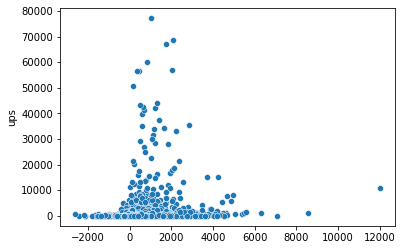

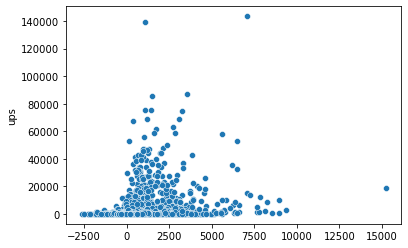

[-0.04540416 -0.26796861 -0.06975051 -0.01889146  0.0127936 ]
working on XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


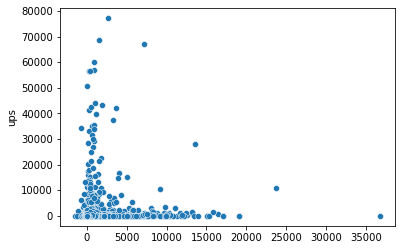

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


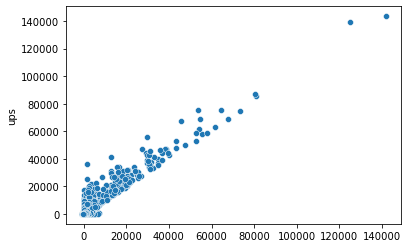

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [18]:
def run_experiment(model, df):
    X = df.drop(columns = ['ups'])
    y = df.ups

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

    print("working on", model)

    pipe = make_pipeline( model)
    pipe.fit(X_train, y_train)


    sns.scatterplot(x = pipe.predict(X_test), y = y_test)
    plt.show()
    sns.scatterplot(x = pipe.predict(X_train), y = y_train)
    plt.show()
    
    scores = cross_val_score(pipe,X,y)
    print(scores)

for model in [LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    run_experiment(model, df[cols + ['ups']])


working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


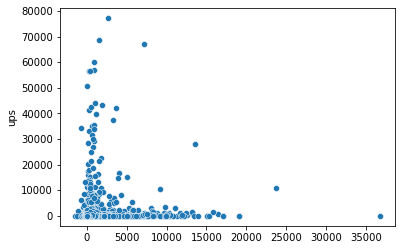

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


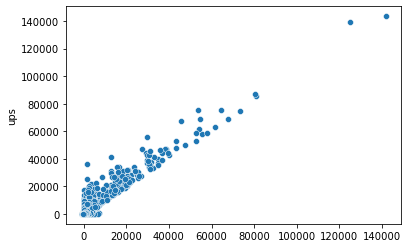

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\env

[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]
working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


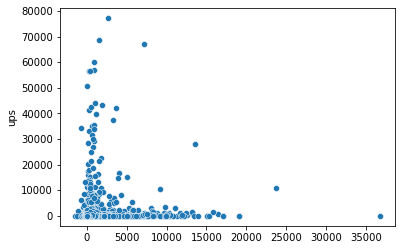

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


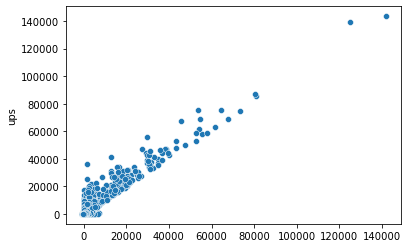

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\env

[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]
working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


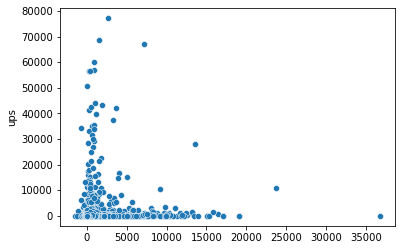

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


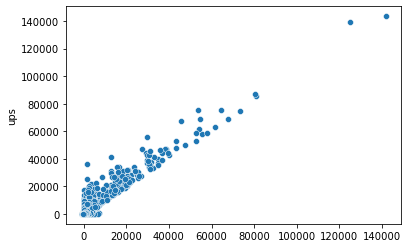

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [19]:

for depth in [2,3,4]:
    
    xgb.XGBRegressor(random_state=2, max_depth = depth, )
    run_experiment(model, df[cols + ['ups']])


working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


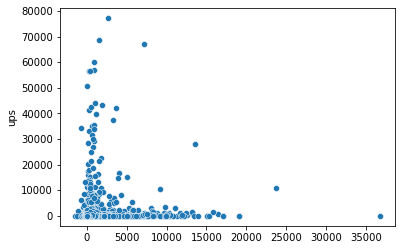

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


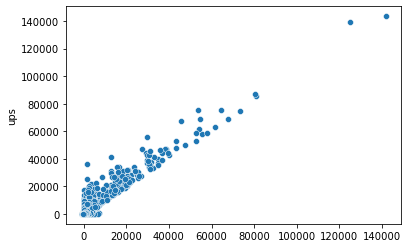

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\env

[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]
working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


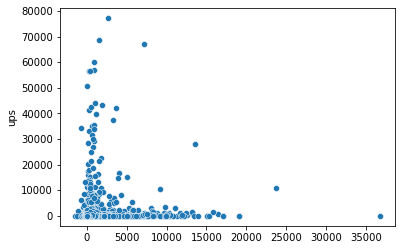

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


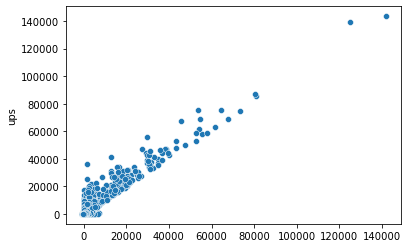

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KeyboardInterrupt: 

In [20]:
from sklearn.ensemble import RandomForestRegressor

for depth in [2,3,4]:
    
    RandomForestRegressor(random_state=2, max_depth = depth, )
    run_experiment(model, df[cols + ['ups']])

In [50]:


X = df[cols + ['ups']].drop(columns = ['ups'])
Y = df[cols + ['ups']].ups

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

eval_set = [(X_test, y_test)]
model = xgb.XGBRegressor(random_state=2, eval_metric="rmse", eval_set=eval_set, verbose=True, max_depth = 1, )


[17:45:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2260.91553	validation_1-rmse:2471.32910
[1]	validation_0-rmse:2224.26758	validation_1-rmse:2489.43628
[2]	validation_0-rmse:2197.95606	validation_1-rmse:2502.00244
[3]	validation_0-rmse:2188.12793	validation_1-rmse:2499.34521
[4]	validation_0-rmse:2169.79492	validation_1-rmse:2516.01660
[5]	validation_0-rmse:2163.70166	validation_1-rmse:2514.65820
[6]	validation_0-rmse:2151.00098	validation_1-rmse:2531.71997
[7]	validation_0-rmse:2144.65967	validation_1-rmse:2531.65381
[8]	validation_0-rmse:2135.56909	validation_1-rmse:2559.60181
[9]	validation_0-rmse:2130.27295	validation_1-rmse:2568.80176
[10]	validation_0-rmse:2125.33081	valid

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


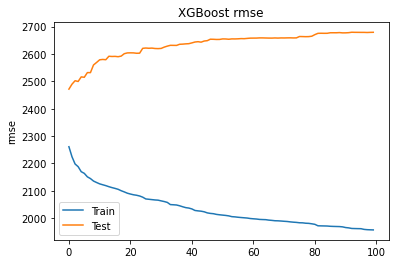

In [51]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model no training data
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()

In [55]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical

In [56]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(28*28,)))

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [57]:
model.compile(optimizer='rmsprop',
                  loss='rmse',
                  metrics=['rmse'])

In [58]:
X_train_train,X_val,y_train_train,y_val = train_test_split(X, y,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

ValueError: Found input variables with inconsistent numbers of samples: [53834, 36068]

In [6]:
####let's first do principal component analysis to cut down on the noise
word_vectors = np.vstack(corpus_df['vector'].to_numpy())

In [15]:
pca=PCA(n_components = .95)
pca.fit(word_vectors)
vars(pca)

{'n_components': 0.95,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 300,
 '_fit_svd_solver': 'full',
 'mean_': array([ 5.35029136e-02,  6.04853518e-02, -2.36557741e-02,  4.49131317e-02,
         3.88098881e-02, -6.21325001e-02,  5.04405871e-02,  1.46542788e-01,
         2.24605314e-02, -5.98826557e-02, -1.18397577e-02, -4.55921665e-02,
         6.47066860e-03,  1.48876570e-03, -4.42986749e-02, -3.40906493e-02,
        -3.55390622e-03, -5.33538265e-03,  5.74947223e-02, -3.01201921e-02,
        -5.28897718e-02, -6.48940802e-02, -2.58796960e-02,  4.48659211e-02,
         1.88251138e-02, -2.81040221e-02, -2.54161917e-02, -4.07190062e-02,
        -5.16786315e-02, -4.11109589e-02,  2.38622609e-03, -5.98169528e-02,
        -7.83489645e-02, -5.47121502e-02, -2.74493713e-02, -1.95759591e-02,
        -1.19688949e-02, -1.14882506e-01, -2.02260632e-03, -5.61718121e-02,
        -9.67798848e-03,  5.03079891e

In [19]:
word_pca=pca.transform(word_vectors)

In [310]:
def Clust(corpus_df, rough_cluster_size=200, num_pc=0.95,random_state=42, inflation=0):
    
    newdf=corpus_df.copy()
    X = np.vstack(newdf['vector'].to_numpy())
    pca=PCA(n_components = num_pc)
    pca.fit(X)
    cluster_model = KMeans(n_clusters= int(len(newdf)/rough_cluster_size),verbose=0, random_state=random_state)
    trans=pca.transform(X)
    cluster_model.fit(trans)
    newdf['prediction'] = cluster_model.predict(trans) + inflation
    return newdf

#Clust(corpus_df)

In [41]:
corpus_df['prediction']

0        14
1         1
2         1
3        14
4        86
         ..
19193    44
19194    44
19195    44
19196    44
19197    44
Name: prediction, Length: 19198, dtype: int32

In [8]:
corpus_df['prediction'].value_counts()

44    9135
0     3084
75     585
80     572
90     529
      ... 
55       2
74       2
81       2
58       1
28       1
Name: prediction, Length: 95, dtype: int64

In [30]:
corpus_df.loc[corpus_df['prediction']==43]

,0,vector,prediction
54,gme,"[-0.2380236, 0.09378845, 0.68115383, -0.729630...",43
155,robinhood,"[0.212802, -0.3709615, 0.03806869, -1.2154461,...",43
226,account,"[-1.1866229, -0.10216711, -0.7424252, -1.14751...",43
478,rh,"[-0.21410583, -0.036077037, -0.50335145, -1.22...",43
550,app,"[0.4971493, 0.2780551, -0.3943224, -0.4850003,...",43
702,broker,"[0.83020234, 0.0007774444, -0.30190995, -0.710...",43
762,accounts,"[-0.5051427, -0.2941858, -0.76400113, -0.01667...",43
992,fidelity,"[-0.29646644, 0.32646507, -0.51328367, -0.8024...",43
1135,brokerage,"[0.45352745, 0.12311299, -0.2442446, -0.903350...",43
1192,td,"[-0.6983725, -0.50126946, -0.96287113, -0.9798...",43


In [33]:
Clust(corpus_df, word_vectors, rough_cluster_size=100, num_pc=0.80,random_state=42)
print(list(corpus_df['prediction'].value_counts()).count(1))
corpus_df['prediction'].value_counts()

6


85     5754
47     3820
3      1213
67     1098
125     702
       ... 
117       1
156       1
170       1
161       1
162       1
Name: prediction, Length: 191, dtype: int64

In [22]:
#corpus_df.loc[corpus_df.prediction==85]

In [21]:
#model.wv.most_similar("dfv", topn = 20)

In [30]:
Clust(corpus_df, word_vectors, rough_cluster_size=100, num_pc=0.9999,random_state=42)
corpus_df['prediction'].value_counts().count(1)

ValueError: Series.count level is only valid with a MultiIndex

In [32]:
list(corpus_df['prediction'].value_counts()).count(1)

21

In [38]:
##let's do the .80 PCA one, then run clustering on its biggest cluster
Clust(corpus_df, rough_cluster_size=100, num_pc=0.80,random_state=42)
corpus_df['prediction'].value_counts()

85     5754
47     3820
3      1213
67     1098
125     702
       ... 
117       1
156       1
170       1
161       1
162       1
Name: prediction, Length: 191, dtype: int64

In [39]:
bigcluster=corpus_df.loc[corpus_df.prediction==85].copy()

In [40]:
Clust(bigcluster, rough_cluster_size=100, num_pc=0.80,random_state=42)
bigcluster['prediction'].value_counts()

3     463
8     429
15    420
25    410
1     394
31    373
36    348
30    327
27    281
51    255
35    253
18    234
24    171
32    168
33    130
28    129
49    128
10    118
16     75
29     73
46     64
13     52
22     52
56     50
47     49
2      48
54     42
7      36
39     30
44     27
14     22
42     18
53     17
9      12
52     11
4       9
26      4
50      4
23      3
43      3
0       3
45      2
41      2
21      2
38      1
34      1
6       1
11      1
19      1
37      1
17      1
5       1
48      1
40      1
20      1
12      1
55      1
Name: prediction, dtype: int64

In [74]:
#for a in bigcluster.index.values:
#    print(a)
#corpus_df['vector'][19196]
corpus_df.at[5,'prediction']=175
corpus_df.at[:,'prediction']

TypeError: 'slice(None, None, None)' is an invalid key

In [311]:
#run Clust on something. count the max cluster number, add that to inflation
def MaxClust(corpus_df, rough_cluster_size=200, num_pc=0.95,random_state=42, inflation=0, max_cluster_size=1000):
    #runs clust, adding prediction column to corpus_df
    newdf=Clust(corpus_df, rough_cluster_size, num_pc,random_state, inflation)
    print(newdf.prediction.value_counts())
    #set inflation (the smallest cluster number available for the future)
    inf=max(newdf.prediction) + 1
    #for each cluster
    for clust in set(newdf.prediction):
        #if there are more than max_cluster_size elements in the cluster:
        if newdf.prediction.value_counts()[clust]>max_cluster_size:
            print(clust)
            #do MaxClust on it, using and then updating inf
            tempdf=MaxClust(newdf.loc[newdf.prediction==clust],rough_cluster_size=rough_cluster_size, 
                     num_pc=num_pc,random_state=random_state, inflation=inf,
                     max_cluster_size=max_cluster_size)
            inf=max(newdf.prediction)+1
            #for each row of newdf that coincides with a row of tempdf, change the value
            for index in tempdf.index.values:
                newdf.at[index,'prediction']=tempdf.prediction[index]
            
    return newdf

In [84]:
testdf=MaxClust(corpus_df, rough_cluster_size=100, num_pc=0.80,random_state=42, inflation=0, max_cluster_size=1000)
testdf.prediction.value_counts()

85     5754
47     3820
3      1213
67     1098
125     702
       ... 
117       1
156       1
170       1
161       1
162       1
Name: prediction, Length: 191, dtype: int64
3
199    432
194    259
198    150
202    150
192     83
195     56
196     43
197     31
191      6
193      1
200      1
201      1
Name: prediction, dtype: int64
47
207    537
193    290
192    260
228    220
210    215
203    201
195    188
217    184
202    163
198    161
227    149
206    133
201    126
204    119
222    119
194    103
200     90
196     86
197     72
211     50
219     48
225     45
223     36
218     35
214     32
216     23
220     23
205     22
208     22
191     22
209     18
224     12
199      8
215      4
213      1
212      1
226      1
221      1
Name: prediction, dtype: int64
67
211    239
207    207
205    142
210    113
203    104
204    104
206     97
208     87
209      4
212      1
Name: prediction, dtype: int64
85
232    463
237    429
244    420
254    410
230    394
260  

207    744
125    702
232    463
153    459
199    440
      ... 
266      1
213      1
246      1
170      1
249      1
Name: prediction, Length: 282, dtype: int64

In [97]:
list(testdf.loc[testdf.prediction==125][0])

['purple',
 'meanwhile',
 'uwmc',
 'costco',
 'bonus',
 'airbnb',
 'starbucks',
 'beats',
 'qs',
 'mac',
 'rumor',
 'blockbuster',
 'mvis',
 'root',
 'doordash',
 'hertz',
 'fedex',
 'buyout',
 'clov',
 'express',
 'volkswagen',
 'whereas',
 'se',
 'nike',
 'de',
 'therapeutics',
 'aso',
 'ex',
 'macys',
 'snowflake',
 'ms',
 'intels',
 'wkhs',
 'mega',
 'gopro',
 'edition',
 'mini',
 'blnk',
 'dash',
 'fisker',
 'kodk',
 'martin',
 'sdc',
 'activision',
 'skt',
 'amds',
 'lumn',
 'clf',
 'snapchat',
 'mo',
 'zillow',
 'allin',
 'lowes',
 'chegg',
 'nintendo',
 'opendoor',
 'logitech',
 'lac',
 'verizon',
 'eric',
 'closest',
 'rated',
 'spotify',
 'eats',
 'dg',
 'ely',
 'soaring',
 'unfi',
 'micron',
 'lk',
 'kroger',
 'nios',
 'quietly',
 'lockheed',
 'msos',
 'ea',
 'cisco',
 'pg',
 'courtesy',
 'tyson',
 'canopy',
 'wayfair',
 'spg',
 'lumber',
 'ko',
 'hbo',
 'quest',
 'tmobile',
 'hyln',
 'ortex',
 'seas',
 'fsr',
 'aurora',
 'blink',
 'viacomcbs',
 'mtch',
 'rival',
 'mcd',
 'o

In [96]:
pd.set_option('display.max_rows', 100)
print(testdf.prediction.value_counts().to_string())
pd.reset_option('display.max_rows')

207    744
125    702
232    463
153    459
199    440
237    429
244    420
254    410
230    394
20     377
260    373
194    362
185    357
265    348
192    343
210    328
259    327
202    313
198    311
203    305
193    291
211    289
256    281
29     269
280    255
264    253
195    244
247    234
206    230
204    223
228    220
92     215
58     206
154    200
0      190
12     184
217    184
78     179
253    171
261    168
205    164
2      161
52     151
227    149
94     147
262    130
257    129
196    129
278    128
201    127
222    119
239    118
208    109
197    103
9      101
104     96
8       95
200     91
186     85
129     83
26      82
84      79
245     75
10      74
258     73
37      72
28      66
275     64
147     59
40      56
32      56
138     55
100     55
164     52
251     52
242     52
16      52
110     50
285     50
134     49
276     49
219     48
231     48
136     46
225     45
143     45
90      44
71      44
23      42
114     42
97      42

In [98]:
nopc=MaxClust(corpus_df, rough_cluster_size=100, num_pc=300,random_state=42, inflation=0, max_cluster_size=1000)
nopc.prediction.value_counts()

55     6842
21     3059
65     1637
0       814
146     653
       ... 
157       1
173       1
189       1
184       1
57        1
Name: prediction, Length: 191, dtype: int64
21
212    695
217    278
196    258
200    230
198    203
191    196
211    168
201    140
208    109
204    106
205     93
192     91
195     78
220     73
213     66
197     56
219     53
202     53
194     34
215     28
193     27
216     15
203      2
210      1
207      1
209      1
206      1
218      1
214      1
199      1
Name: prediction, dtype: int64
55
249    576
198    574
232    543
195    491
235    481
      ... 
201      1
254      1
218      1
229      1
255      1
Name: prediction, Length: 68, dtype: int64
65
228    405
225    251
221    238
222    183
229    172
230     99
224     76
236     58
235     49
223     43
227     27
233     21
232     12
226      1
231      1
234      1
Name: prediction, dtype: int64


0      814
198    777
212    707
146    653
60     639
      ... 
173      1
189      1
178      1
253      1
255      1
Name: prediction, Length: 256, dtype: int64

In [99]:
list(testdf.loc[testdf.prediction==125][0])

['purple',
 'meanwhile',
 'uwmc',
 'costco',
 'bonus',
 'airbnb',
 'starbucks',
 'beats',
 'qs',
 'mac',
 'rumor',
 'blockbuster',
 'mvis',
 'root',
 'doordash',
 'hertz',
 'fedex',
 'buyout',
 'clov',
 'express',
 'volkswagen',
 'whereas',
 'se',
 'nike',
 'de',
 'therapeutics',
 'aso',
 'ex',
 'macys',
 'snowflake',
 'ms',
 'intels',
 'wkhs',
 'mega',
 'gopro',
 'edition',
 'mini',
 'blnk',
 'dash',
 'fisker',
 'kodk',
 'martin',
 'sdc',
 'activision',
 'skt',
 'amds',
 'lumn',
 'clf',
 'snapchat',
 'mo',
 'zillow',
 'allin',
 'lowes',
 'chegg',
 'nintendo',
 'opendoor',
 'logitech',
 'lac',
 'verizon',
 'eric',
 'closest',
 'rated',
 'spotify',
 'eats',
 'dg',
 'ely',
 'soaring',
 'unfi',
 'micron',
 'lk',
 'kroger',
 'nios',
 'quietly',
 'lockheed',
 'msos',
 'ea',
 'cisco',
 'pg',
 'courtesy',
 'tyson',
 'canopy',
 'wayfair',
 'spg',
 'lumber',
 'ko',
 'hbo',
 'quest',
 'tmobile',
 'hyln',
 'ortex',
 'seas',
 'fsr',
 'aurora',
 'blink',
 'viacomcbs',
 'mtch',
 'rival',
 'mcd',
 'o

In [312]:
def GetRelated(df,word):
    return list(df.loc[df.prediction==list(df.loc[df[0]==word].prediction)[0]][0])

In [157]:
GetRelated(testdf,'week')

['day', 'week', 'days', 'years', 'months', 'weeks', 'hours', 'minutes', 'hour']

In [160]:
GetRelated(nopc,'hour')

['day',
 'today',
 'open',
 'close',
 'friday',
 'tomorrow',
 'monday',
 'morning',
 'yesterday',
 'thursday',
 'tuesday',
 'closing',
 'pm',
 'wednesday',
 'night',
 'hour',
 'et',
 'est',
 'eod',
 'afternoon',
 'sunday']

In [164]:
##assumes the file is already open
#def WriteLine(vec,file):
#    for i in range(len(vec)):
#        f.write(str(vec[i]) + " ")
#    f.write("\n")
#
#f = open("corpus.txt", "w")
#for vec in list(corpus_df.vector):
#    WriteLine(vec,f)
#f.close()

In [313]:
#let's experiment with varying amounts of principal components, cluster size 200
df100=MaxClust(corpus_df, rough_cluster_size=200, num_pc=300,random_state=42, inflation=0, max_cluster_size=1000)
df90=MaxClust(corpus_df, rough_cluster_size=200, num_pc=.90, random_state=42, inflation=0, max_cluster_size=1000)
df80=MaxClust(corpus_df, rough_cluster_size=200, num_pc=.80, random_state=42, inflation=0, max_cluster_size=1000)
df70=MaxClust(corpus_df, rough_cluster_size=200, num_pc=.70, random_state=42, inflation=0, max_cluster_size=1000)

81    8479
87    3500
15     838
1      701
23     633
      ... 
84       3
20       3
83       2
22       1
80       1
Name: prediction, Length: 96, dtype: int64
81
110    1413
132     946
106     713
99      624
103     590
107     504
113     477
104     451
102     423
135     385
122     302
112     237
118     219
97      152
96      148
129     137
111     130
130     121
114     104
100      83
123      66
98       61
119      61
109      41
101      21
137      21
127      16
121       7
117       5
115       4
116       2
124       2
131       2
133       2
108       2
105       1
128       1
126       1
134       1
120       1
125       1
136       1
Name: prediction, dtype: int64
110
139    290
143    231
141    224
144    209
138    193
140    156
142    110
Name: prediction, dtype: int64
87
108    833
98     443
110    365
107    316
97     232
112    219
103    216
106    168
109    149
96     127
111    113
101     98
105     97
99      75
104     25
102     23
100    

In [314]:
df60=MaxClust(corpus_df, rough_cluster_size=200, num_pc=.60, random_state=42, inflation=0, max_cluster_size=1000)

46    7690
2     3192
15    1389
25     580
82     548
      ... 
12       9
3        8
62       7
59       4
53       2
Name: prediction, Length: 96, dtype: int64
2
108    784
96     426
100    352
102    212
101    205
104    200
109    196
110    169
97     166
107    114
99      89
103     85
105     77
98      68
106     49
Name: prediction, dtype: int64
15
99     512
96     458
100    227
98      68
101     65
97      59
Name: prediction, dtype: int64
46
144    750
134    701
140    692
119    616
116    589
139    465
126    399
112    395
127    365
148    292
123    284
125    272
114    263
121    238
124    172
136    156
129    148
122    142
133    121
128    116
115    115
111    104
117     98
113     59
141     54
130     49
118     16
138      3
145      3
146      2
142      2
131      2
143      2
132      1
137      1
135      1
120      1
147      1
Name: prediction, dtype: int64


In [315]:
df75=MaxClust(corpus_df, rough_cluster_size=200, num_pc=.75, random_state=42, inflation=0, max_cluster_size=1000)

84    7678
17    3309
12    1003
1      684
76     593
      ... 
33       6
85       6
53       4
91       3
92       2
Name: prediction, Length: 96, dtype: int64
12
96     493
97     348
98      98
99      63
100      1
Name: prediction, dtype: int64
17
108    703
103    529
105    245
97     242
111    241
101    209
104    201
98     191
107    157
96     119
109    112
100    108
106     77
99      76
102     61
110     38
Name: prediction, dtype: int64
84
108    894
124    882
101    712
134    641
133    503
111    500
135    451
116    368
131    366
119    315
102    253
107    221
138    203
109    187
104    185
120    125
122    119
125    114
103    106
121     90
129     67
136     59
128     55
106     52
105     51
130     43
132     39
112     31
114     19
115     11
110      4
123      3
137      3
126      2
113      1
118      1
117      1
127      1
Name: prediction, dtype: int64


In [316]:
GetRelated(df100,'week')

['time',
 'day',
 'week',
 'year',
 'month',
 'quarter',
 'hours',
 'period',
 'weekend',
 'minutes',
 'night',
 'hour',
 'quarters',
 'minute',
 'decade']

In [317]:
GetRelated(df90,'week')

['week',
 'year',
 'days',
 'years',
 'months',
 'weeks',
 'month',
 'quarter',
 'quarters',
 'decade']

In [318]:
GetRelated(df80,'week')

['week',
 'year',
 'years',
 'months',
 'weeks',
 'month',
 'quarter',
 'quarters',
 'decade']

In [319]:
GetRelated(df75,'week')

['day',
 'week',
 'year',
 'days',
 'years',
 'months',
 'weeks',
 'month',
 'hours',
 'minutes',
 'hour',
 'quarters',
 'decade']

In [320]:
GetRelated(df70,'week')

['time',
 'day',
 'week',
 'year',
 'days',
 'years',
 'months',
 'weeks',
 'month',
 'quarter',
 'hours',
 'minutes',
 'hour',
 'quarters',
 'decade']

In [321]:
GetRelated(df100,'gme')

['gme',
 'amc',
 'p',
 'tsla',
 'tldr',
 'pltr',
 'bb',
 'nok',
 'nio',
 'amd',
 'amzn',
 'aapl',
 'spce',
 'msft',
 'rkt',
 'ticker',
 'exp',
 'ps',
 'slv',
 'nkla',
 'f',
 'symbol',
 'prpl',
 'vol',
 'baba',
 'fb',
 'snap',
 'vxx',
 'ba',
 'nvda',
 'dis',
 'tlry',
 'pton',
 'apha',
 'qqq',
 'atm',
 'aal',
 'uso',
 'zm',
 'xbtldr',
 'ccl',
 'sndl',
 'bbby',
 'dkng',
 'vale',
 'crsr',
 'aug',
 'gld',
 'nflx',
 'intc',
 'jpm',
 'nakd',
 'mar',
 'bynd',
 'gild',
 'avg',
 'weeklies',
 'leap',
 'wmt',
 'mooning',
 'roku',
 'pfe',
 'expr',
 'apr',
 'fd',
 'sq',
 'oi',
 'atvi',
 'dte',
 'acb',
 'mgm',
 'lyft',
 'cs',
 'tqqq',
 'sep',
 'twtr',
 'bac',
 'apt',
 'uvxy',
 'sbux',
 'fsly',
 'nclh',
 'tlt',
 'jun',
 'dal',
 'bby',
 'rcl',
 'xpev',
 'iwm',
 'tgt',
 'ual',
 'jul',
 'xom',
 'goog']

In [322]:
GetRelated(df90,'gme')

['gme',
 'amc',
 'moon',
 'tsla',
 'tesla',
 'pltr',
 'bb',
 'nok',
 'nio',
 'stonks',
 'rocket',
 'meme',
 'pump',
 'spce',
 'rkt',
 'ticker',
 'hype',
 'dump',
 'split',
 'nkla',
 'stonk',
 'train',
 'ship',
 'fomo',
 'mars',
 'penny',
 'sndl',
 'hop']

In [323]:
GetRelated(df80,'gme')

['or',
 'gme',
 'spy',
 'instead',
 'covered',
 'theta',
 'weekly',
 'exp',
 'buys',
 'slv',
 'leaps',
 'naked',
 'holders',
 'worthless',
 'vol',
 'warrants',
 'depending',
 'overnight',
 'debit',
 'premiums',
 'vxx',
 'fds',
 'bid',
 'qqq',
 'remaining',
 'atm',
 'dated',
 'uso',
 'dates',
 'spx',
 'hedging',
 'unusual',
 'gld',
 'hedges',
 'longs',
 'squeezes',
 'weeklies',
 'leap',
 'exercised',
 'fd',
 'decay',
 'oi',
 'synthetic',
 'dte',
 'expired',
 'expires',
 'assigned',
 'vertical',
 'sides',
 'tqqq',
 'holder',
 'vega',
 'uvxy',
 'greeks',
 'straddle',
 'tlt',
 'jun',
 'hedged',
 'iwm',
 'jul',
 'bidask',
 'cc',
 'condor',
 'expirations',
 'strangle',
 'straddles',
 'condors']

In [324]:
GetRelated(df75,'gme')

['gme',
 'shares',
 'short',
 'positions',
 'interest',
 'position',
 'hedge',
 'risk',
 'shorts',
 'silver',
 'side',
 'float',
 'shorting',
 'covered',
 'gamma',
 'bonds',
 'institutional',
 'etfs',
 'pressure',
 'naked',
 'holders',
 'leveraged',
 'covering',
 'ladder',
 'hedging',
 'hedges',
 'longs']

In [325]:
GetRelated(df70,'gme')

['stock',
 'gme',
 'amc',
 'tsla',
 'pltr',
 'bb',
 'gamestop',
 'nok',
 'gold',
 'silver',
 'stonks',
 'meme',
 'spce',
 'etf',
 'ticker',
 'hype',
 'slv',
 'stonk',
 'penny']

In [326]:
GetRelated(df60,'gme')

['stock',
 'gme',
 'shares',
 'short',
 'trading',
 'buying',
 'selling',
 'holding',
 'hedge',
 'trades',
 'gold',
 'silver',
 'shorted',
 'shorting',
 'covered',
 'etf',
 'etfs',
 'buys',
 'naked',
 'holders',
 'warrants',
 'leveraged']

In [331]:
X = np.vstack(corpus_df['vector'].to_numpy())
pca=PCA(n_components = .8)
pca.fit(X)
vars(pca)

{'n_components': 0.8,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 300,
 '_fit_svd_solver': 'full',
 'mean_': array([ 2.12316494e-02,  1.04184657e-01, -3.47388238e-02,  4.72811162e-02,
         1.58385374e-02, -5.16514517e-02,  6.49116561e-02,  1.80211768e-01,
         4.76700664e-02, -5.29301651e-02,  4.65496536e-03, -5.35055958e-02,
         2.08424078e-03, -7.02013634e-03, -4.32343446e-02, -9.91247687e-03,
         8.34223535e-03, -5.42406645e-03,  7.89513066e-02, -6.65956214e-02,
        -5.49880527e-02, -2.22850777e-02, -2.26410013e-02,  3.65214050e-02,
         1.57206673e-02, -1.79922655e-02, -4.71974351e-02, -3.19125913e-02,
        -5.79454266e-02, -7.71146780e-03, -1.08548263e-02, -8.47870782e-02,
        -5.68846762e-02, -4.06803340e-02, -4.24795598e-02, -3.14957537e-02,
        -1.12315165e-02, -1.07471131e-01, -5.76681644e-02, -2.91697532e-02,
        -2.03880034e-02,  4.89906184e-